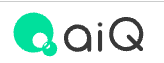

[disclaimer](./disclaimer.txt/)

# ALTERNATIVE DATA Evaluation Demo

## Evaluate aiQ POS Csmr Goods using aiQ Lab Alt Data Evaluation Tool

### Step1: Import Library

In [2]:
import numpy as np
import pandas as pd
import plotly.io as pio
pio.renderers.default = 'iframe'

from aiq_strategy_robot.data.data_accessor import DAL, FactsetDataLoader, StdDataLoader, AlternativeDataLoader

In [3]:
sdh = DAL('ALTERNATIVE')

### Step2: Define Universe from Alt Data
Normally, a list of tickers is picked by users.
However it is made equal to the list of tickers found in aiQ POS Csmr Goods dataset for this demo.

In [4]:
sdh = sdh.load(
    data_type='aiq_pos_csmr_goods',
    meta_data='universe'
)
dfsyms = sdh.retrieve()
dfsyms = dfsyms.rename({'TICKER': 'seccode'}, axis=1)
list_tickers = dfsyms['seccode'].unique().tolist()
list_figis = dfsyms['FIGI'].unique().tolist()
dfsyms.head()

,FIGI,seccode
0,BBG009XY5263,3417
1,BBG000BHVT83,2208
2,BBG000C2W265,2922
3,BBG00195NFY0,4928
4,BBG000DPW4P8,4574


#### Step 2.1: Find FACTSET IDs

In [5]:
sdh.set_loader(override_loader=FactsetDataLoader())
sdh = sdh.load(
    data_type='symbol_lookup',
    figi=list_figis,
    pick_only_primary=True
)
dfsyms2 = sdh.retrieve(pick_cols=['FIGI', 'TICKER', 'FSYM_ID', 'FSYM_SECURITY_ID']).sort_values('TICKER', ascending=True)
dfsyms2 = dfsyms2.drop_duplicates(keep='last')
dfsyms2 = dfsyms2.merge(dfsyms, on='FIGI', how='left')
list_tickers = dfsyms2['TICKER'].unique().tolist()
dfsyms2.head()

,FIGI,TICKER,FSYM_ID,FSYM_SECURITY_ID,seccode
0,BBG000BH56Z2,1301-JP,D0HPMH-R,V84SN8-S,1301
1,BBG000BH5GX2,1332-JP,MCQXPF-R,DBQDNQ-S,1332
2,BBG001HX4YF1,1333-JP,H32P6P-R,D9X98N-S,1333
3,BBG000DNK6F2,1379-JP,J1DWSG-R,FPW2T0-S,1379
4,BBG000BVJLV7,1380-JP,VPYRWX-R,FWDLXZ-S,1380


### Step3: Load Alternative Data

In [6]:
# loading from csv to save time for this demo
load_from_csv = True
if load_from_csv:
    df_pos = pd.read_parquet('aiq_pos_csmr_goods_sample.parquet')
    df_pos = df_pos.merge(dfsyms2[['seccode', 'TICKER']], left_on='ticker', right_on='seccode', how='inner').drop(['seccode', 'ticker'], axis=1)
    df_pos = df_pos.rename(columns={'TICKER': 'ticker', 'DATETIME': 'datetime'})
    df_pos = df_pos.set_index(['ticker', 'datetime'])
else:
    sdh.set_loader(override_loader=AlternativeDataLoader())
    sdh = sdh.load(
        data_type='aiq_pos_csmr_goods',
        meta_data='data',
        generation=2,
        figi=list_figis,
        load_only_raw=True,
        load_only_latest=True
    )
    df_pos = sdh.retrieve()
df_pos.head()

pos_sales     share  unit_price  unit_price_vs_ind
ticker  datetime                                                      
1301-JP 2008-03-16   0.716136  0.036918    1.061700           0.794193
        2008-03-23   0.713317  0.036813    1.092624           0.825687
        2008-03-30   0.673215  0.033429    0.995762           0.745105
        2008-04-06   0.788698  0.036580    1.053193           0.781361
        2008-04-13   0.846764  0.039811    1.033405           0.777337

#### Step3.1: Register the extract to data handler

In [7]:
data_id_alt = sdh.set_raw_data(
    data_source='external',
    dfraw=df_pos,
    tickers=df_pos.index.get_level_values('ticker').unique().tolist(),
    index=['ticker', 'datetime']
)

In [8]:
# Check if the data is registered OK.
sdh.extract_definition

,category,data_source,source,table,alias,exchanges,tickers,start_datetime,end_datetime,index
data_id,,,,,,,,,,
1,RawData,external,None,Unknown,Unknown,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-16T00:00:00,2024-03-03T00:00:00,"[ticker, datetime]"


### Step4: Load fundamental data and market data

#### Step 4.1: Load Fundamental Data

In [9]:
if True:
    df_fundamental = pd.read_parquet('aiq_pos_csmr_goods_fundamental.parquet', engine='pyarrow')
else:
    start_datetime = sdh.extract_definition.loc[data_id_alt]['start_datetime'].split('T')[0]
    sdh.set_loader(override_loader=FactsetDataLoader())
    sdh = sdh.load(
        data_type='fundamental',
        symbols=dfsyms2['FSYM_ID'].unique().tolist(),
        freq=3,
        start_datetime=start_datetime
    )
    df_fundamental = sdh.retrieve(pick_cols=['FSYM_ID', 'DATE', 'FF_FPNC', 'FF_SALES'])
    df_fundamental = df_fundamental.merge(dfsyms2[['FSYM_ID', 'TICKER']], on='FSYM_ID', how='left')
    df_fundamental = df_fundamental.sort_values(['TICKER', 'DATE'], ascending=[True, True])
    df_fundamental = df_fundamental[['TICKER', 'DATE', 'FF_SALES']].rename(columns={'TICKER': 'ticker', 'DATE': 'datetime', 'FF_SALES': 'sales'})
    df_fundamental['datetime'] = pd.to_datetime(df_fundamental['datetime'])
    df_fundamental = df_fundamental.set_index(['ticker', 'datetime'])
    df_fundamental.to_parquet('aiq_pos_csmr_goods_fundamental.parquet', engine='pyarrow')

In [10]:
data_id_funda = sdh.set_raw_data(
    data_source='external',
    dfraw=df_fundamental,
    tickers=df_fundamental.index.get_level_values('ticker').unique().tolist(),
    index=['ticker', 'datetime']
)

In [11]:
# Check if the data is registered OK.
sdh.extract_definition

,category,data_source,source,table,alias,exchanges,tickers,start_datetime,end_datetime,index
data_id,,,,,,,,,,
1,RawData,external,None,Unknown,Unknown,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-16T00:00:00,2024-03-03T00:00:00,"[ticker, datetime]"
2,RawData,external,None,Unknown,Unknown2,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-31T00:00:00,2024-01-31T00:00:00,"[ticker, datetime]"


#### Step4.2: Load market data

In [12]:
# we load from the parquet file to speed up the demo.
if True:
    dfmkt = pd.read_parquet('aiq_pos_csmr_goods_mkt.parquet', engine='pyarrow')
else:
    dfmkt = sdh.load(
        data_type='gpd_prices',
        ids=dfsyms2['TICKER'].unique().tolist(),
        start_date=start_datetime,
        adjust='SPLIT',
        fields=['price', 'vwap', 'volume', 'turnover']
    ).retrieve()
    dfmkt = dfmkt.reset_index().rename(columns={'DATETIME': 'datetime'})
    dfmkt['datetime'] = pd.to_datetime(dfmkt['datetime'])
    dfmkt = dfmkt.set_index(['ticker', 'datetime'])[['close']]
    dfmkt.to_parquet('aiq_pos_csmr_goods_mkt.parquet', engine='pyarrow')

In [13]:
data_id_mkt = sdh.set_raw_data(
    data_source='external',
    dfraw=dfmkt,
    tickers=list_tickers,
    index=['ticker', 'datetime']
)

In [14]:
sdh.set_alias({
    data_id_alt: 'aiq_pos_csmr_goods',
    data_id_funda: 'fundamental',
    data_id_mkt: 'market'
})

In [15]:
# Check if the data is registered OK.
sdh.extract_definition

,category,data_source,source,table,alias,exchanges,tickers,start_datetime,end_datetime,index
data_id,,,,,,,,,,
1,RawData,external,None,Unknown,aiq_pos_csmr_goods,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-16T00:00:00,2024-03-03T00:00:00,"[ticker, datetime]"
2,RawData,external,None,Unknown,fundamental,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-31T00:00:00,2024-01-31T00:00:00,"[ticker, datetime]"
3,RawData,external,None,Unknown,market,None,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...",2008-03-14T00:00:00,2024-03-22T00:00:00,"[ticker, datetime]"


In [16]:
sdh.get_raw_data(data_id_alt)

pos_sales     share  unit_price  unit_price_vs_ind
ticker  datetime                                                      
1301-JP 2008-03-16   0.716136  0.036918    1.061700           0.794193
        2008-03-23   0.713317  0.036813    1.092624           0.825687
        2008-03-30   0.673215  0.033429    0.995762           0.745105
        2008-04-06   0.788698  0.036580    1.053193           0.781361
        2008-04-13   0.846764  0.039811    1.033405           0.777337
...                       ...       ...         ...                ...
9997-JP 2024-02-04   0.012324  0.000572    0.691312           0.493701
        2024-02-11   0.005229  0.000243    0.829920           0.575624
        2024-02-18   0.008494  0.000395    0.813988           0.557915
        2024-02-25   0.006700  0.000317    0.768075           0.509813
        2024-03-03   0.008056  0.000368    0.798211           0.560644

[181504 rows x 4 columns]

### Step5: Correlation Analysis

In [17]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

#### Step 5.1: measuring usefulness against fundamentals


In [18]:
resample_term='Q'
ade = AltDataEvaluator(
    sdh,
    data_id_alt=data_id_alt,
    data_id_y=data_id_funda,
    resample_term=resample_term,
    ytype='fundamental',
    pre_shift=1
)

divide by zero encountered in log


In [19]:
rho_pool = pd.DataFrame()
features = ade.dfalt.columns
rho_pool['n_shift=0, n_rolling=0, yoy'] = ade.compu_rho(features, 'sales', n_smart_diff=0, n_shift=0, n_rolling=0, n_log_diff=4)
rho_pool['n_shift=1, n_rolling=0, yoy'] = ade.compu_rho(features, 'sales', n_smart_diff=0, n_shift=1, n_rolling=0, n_log_diff=4)

In [20]:
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,"n_shift=0, n_rolling=0, yoy","n_shift=1, n_rolling=0, yoy"
pos_sales,2.304299,0.519517
share,1.279307,-0.156069
unit_price,0.826965,-0.127278
unit_price_vs_ind,-0.373179,-0.508477


#### Ticker-by-ticker result can be viewed as follows

In [21]:
rho_time = ade.compu_rho(features, 'sales', n_smart_diff=0, n_shift=0, n_log_diff=4, by='ticker')
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False)

,pos_sales,share,unit_price,unit_price_vs_ind
ticker,,,,
2931-JP,2.616977,2.679280,-1.801023,1.174315
2930-JP,2.401383,2.495697,-0.943399,-1.826104
2281-JP,2.360260,1.481427,1.583392,1.783432
2919-JP,1.955477,-0.709629,1.174129,1.224343
2226-JP,1.872784,1.679156,0.982608,0.365046
...,...,...,...,...
4188-JP,-1.022701,0.127406,-0.070680,0.742438
1332-JP,-1.045319,0.091845,0.388594,0.168905
1301-JP,-1.052284,0.168481,0.198979,-0.226945


#### Step 5.2: measuring usefulness against market data
Likewise, the same evaluation can be done for market price returns.
In this example, how quarterly aggregated alternative data correlates with market_price returns is measured.

In [22]:
resample_term = 'W'
ade_mkt = AltDataEvaluator(
    sdh,
    data_id_alt=data_id_alt,
    data_id_y=data_id_mkt,
    resample_term=resample_term
)

In [23]:
rho_pool = pd.DataFrame()
features = ade.dfalt.columns

# define factor creation methods.
rho_pool['n_shift=1, n_rolling=12'] = ade_mkt.compu_rho(features, 'ret', n_smart_diff=0, n_shift=1, n_rolling=12, n_log_diff=52)
rho_pool['n_shift=2, n_rolling=12'] = ade_mkt.compu_rho(features, 'ret', n_smart_diff=0, n_shift=2, n_rolling=12, n_log_diff=52)
rho_pool['n_shift=1, n_rolling=16'] = ade_mkt.compu_rho(features, 'ret', n_smart_diff=1, n_shift=1, n_rolling=16, n_log_diff=52)
rho_pool['n_shift=1, n_rolling=8'] = ade_mkt.compu_rho(features, 'ret', n_smart_diff=0, n_shift=1, n_rolling=8, n_log_diff=52)

divide by zero encountered in log
invalid value encountered in log
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract


In [24]:
# view an aggregated result by features.
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

,"n_shift=1, n_rolling=12","n_shift=2, n_rolling=12","n_shift=1, n_rolling=16","n_shift=1, n_rolling=8"
pos_sales,6.578173,6.316196,2.586472,5.795810
share,3.166150,3.076840,0.143092,3.013613
unit_price,0.927105,1.118636,-0.452432,0.431611
unit_price_vs_ind,-1.362185,-1.233253,1.012851,-1.390278


### Step6: Quantile Backtest

In [31]:
# define the parameters for factor choice.
feature = 'pos_sales'
n_shift = 1
n_rolling = 12
n_log_diff = 52
n_smart_diff = 0
nq = 3
exe_cost = 0.0005

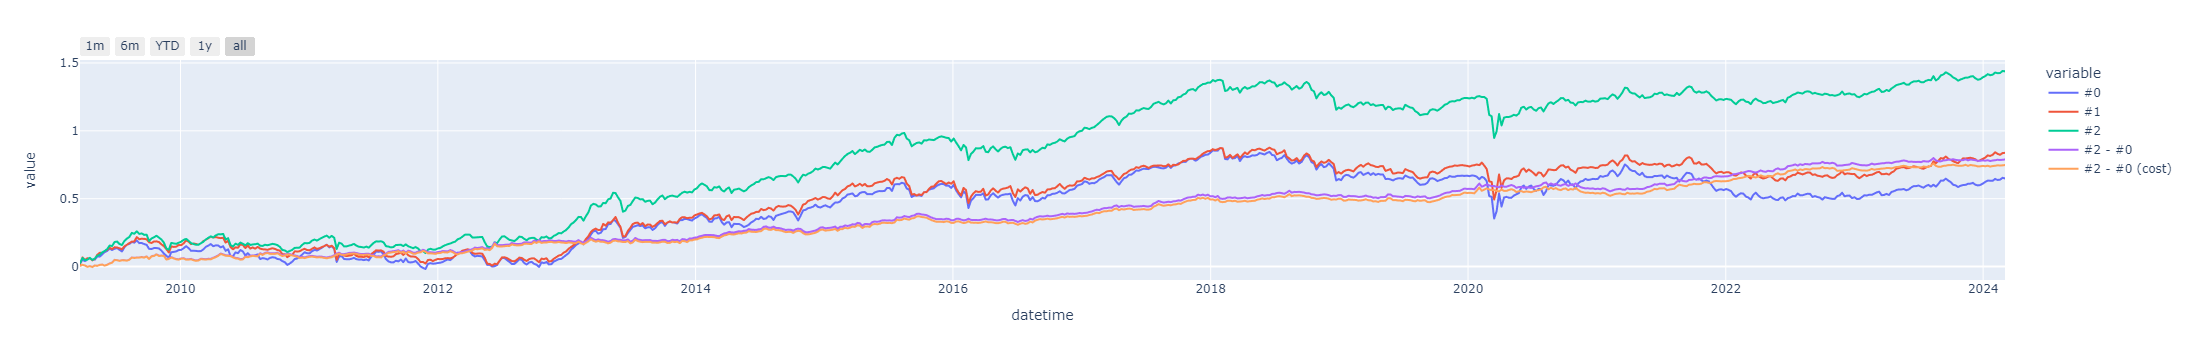

,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver
#0,0.043402,0.143379,0.302710,0.569231,2.789957
#1,0.056016,0.135917,0.412135,0.574359,5.150093
#2,0.096153,0.140245,0.685611,0.600000,2.703634
#2 - #0,0.052751,0.049584,1.063879,0.569231,5.493591
#2 - #0 (cost),0.050004,0.049584,1.008487,0.560819,5.493591


In [32]:
dfqret, dfsigqt = ade_mkt.q_backtest(
    feature,
    'ret',
    nq=nq,
    n_shift=n_shift,
    n_rolling=n_rolling,
    n_smart_diff=n_smart_diff,
    n_log_diff=n_log_diff,
    qmax=None,
    qmin=None,
    exe_cost=exe_cost,
    plot=True,
    run_mlflow=False
)